In [1]:
import numpy as np
from scipy.interpolate import RegularGridInterpolator
import matplotlib.pyplot as plt
import matplotlib as mpl
from comp_pdet import pdet
from tqdm.auto import tqdm
from joblib import Parallel, delayed
import logging

/data/fdesanti/fleto/master_thesis/box/lib/python3.11/site-packages/gwbench/basic_relations.py:20: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  from lal import GreenwichMeanSiderealTime


In [2]:
pdet(8, 10, 0.3, n_samples=1e4)

1.0

Combinations of masses and redshifts for which the detection probability is virtually 1 (0.999#) or 0 (0.000#) for a CE (US A location) + ET (Sardinia) network and SNR threshold $8 \sqrt{2}$:

* $p_\text{det} \simeq 1$
    * Anything with $z \leq 0.1$ (and $m_\text{min} \geq 1$)
    * Anything with $z \leq 1$ and $m_\text{min} \geq 30$
    * Anything with $z \leq 2$ and $m_\text{min} \geq 75$
* $p_\text{det} \simeq 0$
    * Anything with $z \geq 6$ and $m_\text{max} \leq 10$

In [3]:
z_min_compute = 0.1
z_max_m_min = ((0.1, 1), (1, 30), (2, 75))
z_min_m_max = ((6, 10),)

In [4]:
m1grid = np.concatenate((np.linspace(1, 20, 20, endpoint=False), np.linspace(20, 50, 20, endpoint=False), np.linspace(50, 100, 20)))
m2grid = np.concatenate((np.linspace(1, 20, 20, endpoint=False), np.linspace(20, 50, 20, endpoint=False), np.linspace(50, 100, 20)))
zgrid = np.concatenate((np.geomspace(1e-4, 1e-1, 100, endpoint=False), np.geomspace(1e-1, 1, 50, endpoint=False), np.geomspace(1, 10, 50)))

grids = (m1grid, m2grid, zgrid)
pdet_for_interpolant = np.zeros([len(grid) for grid in grids])

In [5]:
meshcoord = []
meshgrid = []

n_iter = 0
for i, m1 in enumerate(m1grid):
    for j, m2 in zip(range(i, len(m2grid)), m2grid[i:]):
        for k, z in enumerate(zgrid):
            n_iter += 1

with tqdm(total=n_iter, desc="Populating pdet_for_interpolant and meshgrid") as pbar:
    for i, m1 in enumerate(m1grid):
        for j, m2 in zip(range(i, len(m2grid)), m2grid[i:]):
            for k, z in enumerate(zgrid):
                already_known=False
                m12_min = m1 if m1 <= m2 else m2
                for z_max, m_min in z_max_m_min:
                    if z <= z_max and m12_min >= m_min:
                        pdet_for_interpolant[i, j, k] = 1
                        pdet_for_interpolant[j, i, k] = 1
                        already_known=True
                if not already_known:
                    m12_max = m1 if m1 >= m2 else m2
                    for z_min, m_max in z_min_m_max:
                        if z >= z_min and m12_max <= m_max:
                            already_known=True
                if not already_known:
                    meshcoord.append((i, j, k))
                    meshgrid.append((m1 ,m2, z))
                pbar.update(1)

meshcoord = np.array(meshcoord)
meshgrid = np.array(meshgrid)

# Shuffle the arrays to better ditribute load across processors
p = np.random.permutation(len(meshcoord))

meshcoord = meshcoord[p]
meshgrid = meshgrid[p]

print(np.prod(pdet_for_interpolant.shape), meshcoord.shape)

Populating pdet_for_interpolant and meshgrid:   0%|          | 0/366000 [00:00<?, ?it/s]

720000 (151745, 3)


In [6]:
def compute_pdet_for_interpolant(meshgrid, meshcoord=None, m1grid=None, m2grid=None, zgrid=None, pdet_for_interpolant=None, n_sample=1e3, n_jobs=-1, verbose=11, from_checkpoint=False, save_checkpoint=False, checkpoint_file_path="", save_step=100):
    chunks_integrity_error_msg = "Ops, something went wrong while splitting meshgrid and meshcoords. Hopefully you will never see this message."
    logging.basicConfig(filename="pdet_gwbench_grid_making.log",
                        level=logging.INFO,
                        format="%(asctime)s - %(levelname)s - %(message)s")
    if not from_checkpoint:
        if not save_checkpoint: # Just return meshevalues
            meshvalues = np.array(Parallel(n_jobs=n_jobs, verbose=verbose)(delayed(pdet)(m1, m2, z, n_samples=n_sample, n_jobs=1) for m1, m2, z in meshgrid))
            return meshvalues
        else:
            # Check parameters
            assert checkpoint_file_path != "", "Provide a checkpoint file path. Extension is not needed if the checkpoint file doesn't exist yet."
            assert meshcoord is not None, "Provide also the meshcoord array. It will be saved in the checkpoint file."
            assert meshgrid.shape == meshcoord.shape, "Check the shapes of the arrays."
            pars_present = [par is not None for par in (m1grid, m2grid, zgrid, pdet_for_interpolant)]
            pars_are_present = True
            for par_is_present in pars_present:
                pars_are_present = pars_are_present and par_is_present
            assert pars_are_present, "Provide also the m1grid, m2grid, zgrid and pdet_for_interpolant arrays. They will be saved in the checkpoint file."
            assert 1 <= save_step <= len(meshgrid), f"The saving step must be greater than 1 and smaller than the length of meshgrid ({len(meshgrid)})."
            logging.info("Starting pdet computation with gwbench on the provided m1, m2, z grid using checkpoint file...")
            logging.info(f"Splitting grids into chunks with length of roughly {save_step}.")
            # Split the grid into chunks based on save_step parameter
            mgridchunks = np.array_split(meshgrid, int(len(meshgrid) / save_step))
            mcoordchunks = np.array_split(meshcoord, int(len(meshcoord) / save_step))
            # Check chunks integrity
            assert sum([len(grid) for grid in mgridchunks]) == len(meshgrid) and sum([len(grid) for grid in mcoordchunks]) == len(meshcoord), chunks_integrity_error_msg
            chunks_lengths = [len(chunk) for chunk in mgridchunks]
            logging.info(f"Grids with length of {len(meshgrid)} divided into {len(mgridchunks)} chunks. " +
                         f"{chunks_lengths.count(min(chunks_lengths))} with length {min(chunks_lengths)} and {chunks_lengths.count(max(chunks_lengths))} with length {max(chunks_lengths)}")
            
            # Initialize results variables
            completed_tasks = 0
            meshvalues = np.array([])

            # Initialize checkpoint file.
            # n_sample and completed_tasks are not arrays, therefore you will need to int() the 0-dim array associated with them while reading the file
            logging.info(f"Initializing checkpoint file at {checkpoint_file_path}.")
            np.savez(checkpoint_file_path, m1grid=m1grid, m2grid=m2grid, zgrid=zgrid, pdet_for_interpolant=pdet_for_interpolant, meshgrid=meshgrid, meshcoord=meshcoord, n_sample=n_sample, meshvalues=meshvalues, completed_tasks=completed_tasks)
            logging.info(f"Checkpoint file created at {checkpoint_file_path}.")
            
            # Compute and save the meshvalues for each chunk
            logging.info("Starting pdet computation...")
            for i, (mgrid, mcoord) in enumerate(zip(mgridchunks, mcoordchunks)):
                assert len(mgrid) == len(mcoord), chunks_integrity_error_msg
                logging.info(f"Working on chunk n. {i + 1} of {len(mgridchunks)}. {completed_tasks} of {len(meshgrid)} tasks completed.")
                mvalues = np.array(Parallel(n_jobs=n_jobs, verbose=verbose)(delayed(pdet)(m1, m2, z, n_samples=n_sample, n_jobs=1) for m1, m2, z in mgrid))
                meshvalues = np.concatenate((meshvalues, mvalues))
                completed_tasks += len(mgrid)
                np.savez(checkpoint_file_path, m1grid=m1grid, m2grid=m2grid, zgrid=zgrid, pdet_for_interpolant=pdet_for_interpolant, meshgrid=meshgrid, meshcoord=meshcoord, n_sample=n_sample, meshvalues=meshvalues, completed_tasks=completed_tasks)
                logging.info("Chunk completed. Progress saved.")

            logging.info("Computation completed.")
            # If everything went smooth, return meshvalues
            return meshvalues
    else: # Any parameter but for n_jobs, verbose and save_step will be ignored
        assert checkpoint_file_path != "", "Provide an existing checkpoint file path."
        logging.info("Resuming pdet computation from checkpoint file...")
        # Load the checkpoint file
        logging.info(f"Loading the checkpoint file at {checkpoint_file_path}.")
        chk_file = np.load(checkpoint_file_path)
        logging.info(f"Checkpoint file at {checkpoint_file_path} loaded.")
        
        # Check parameters
        completed_tasks = int(chk_file['completed_tasks'])
        meshgrid = chk_file['meshgrid']
        if completed_tasks >= len(meshgrid):
            chk_file.close()
        assert completed_tasks < len(meshgrid), "Checkpoint file exhausted. Read meshvalues from the file"
        assert 1 <= save_step <= len(meshgrid[completed_tasks:]), f"The saving step must be greater than 1 and smaller than the length of the remaining meshgrid ({len(meshgrid[completed_tasks:])})."

        # Load the remaining variables
        n_sample = int(chk_file['n_sample'])
        meshvalues = chk_file['meshvalues']
        meshcoord = chk_file['meshcoord']
        m1grid = chk_file['m1grid']
        m2grid = chk_file['m2grid']
        zgrid = chk_file['zgrid']
        pdet_for_interpolant = chk_file['pdet_for_interpolant']
        chk_file.close()

        logging.info(f"{len(meshgrid[completed_tasks:]) - completed_tasks} remaining.")

        # Split the remaining grid into chunks based on save_step parameter
        logging.info(f"Splitting remaining grids into chunks with length of roughly {save_step}.")
        mgridchunks = np.array_split(meshgrid[completed_tasks:], int(len(meshgrid[completed_tasks:]) / save_step))
        mcoordchunks = np.array_split(meshcoord[completed_tasks:], int(len(meshcoord[completed_tasks:]) / save_step))
        # Check chunks integrity
        assert sum([len(grid) for grid in mgridchunks]) == len(meshgrid[completed_tasks:]) and sum([len(grid) for grid in mcoordchunks]) == len(meshcoord[completed_tasks:]), chunks_integrity_error_msg
        chunks_lengths = [len(chunk) for chunk in mgridchunks]
        logging.info(f"Remaining grids with length of {len(meshgrid[completed_tasks:])} divided into {len(mgridchunks)} chunks. " +
                     f"{chunks_lengths.count(min(chunks_lengths))} with length {min(chunks_lengths)} and {chunks_lengths.count(max(chunks_lengths))} with length {max(chunks_lengths)}")

        # Compute and save the meshvalues for each chunk
        logging.info("Resuming pdet computation...")
        for i, (mgrid, mcoord) in enumerate(zip(mgridchunks, mcoordchunks)):
            assert len(mgrid) == len(mcoord), chunks_integrity_error_msg
            logging.info(f"Working on chunk n. {i + 1} of {len(mgridchunks)}. {completed_tasks} of {len(meshgrid)} tasks completed.")
            mvalues = np.array(Parallel(n_jobs=n_jobs, verbose=verbose)(delayed(pdet)(m1, m2, z, n_samples=n_sample, n_jobs=1) for m1, m2, z in mgrid))
            meshvalues = np.concatenate((meshvalues, mvalues))
            completed_tasks += len(mgrid)
            np.savez(checkpoint_file_path, m1grid=m1grid, m2grid=m2grid, zgrid=zgrid, pdet_for_interpolant=pdet_for_interpolant, meshgrid=meshgrid, meshcoord=meshcoord, n_sample=n_sample, meshvalues=meshvalues, completed_tasks=completed_tasks)
            logging.info("Chunk completed. Progress saved.")

        logging.info("Computation completed.")
        if completed_tasks != len(meshgrid):
            logging.warning(f"There is a mismatch between the length of meshgrid ({len(meshgrid)}) and the completed tasks ({completed_tasks})")
        # If everything went smooth, return all the grids, both meshed and non-meshed
        return m1grid, m2grid, zgrid, pdet_for_interpolant, meshgrid, meshcoord, meshvalues

In [7]:
file = np.load("data/pdet_nsamples_1e2_zmc_7e-2_(attempt_1).npz")
m1grid, m2grid, zgrid, pdet_for_interpolant = [file[key] for key in file.files]
grids = (m1grid, m2grid, zgrid)

In [8]:
pdet_interpolant = RegularGridInterpolator(grids, pdet_for_interpolant)

In [9]:
pdet_interpolant(np.array([[10, 10, 1],
                           [24, 37, 5]]))

array([0.97852874, 0.50221642])

In [10]:
seed = 42
np.random.seed(seed)
m1test = np.random.uniform(1, 100, 1000)
m2test = np.random.uniform(1, 100, 1000)
ztest = np.concatenate((10 ** np.random.uniform(-2, 0, 500), np.random.uniform(1, 10, 500)))

In [11]:
interpolated_pdet = pdet_interpolant(np.vstack((m1test, m2test, ztest)).T)

In [12]:
file = np.load("data/pdet_test_nsamples_1e2_npoints_1e3_seed_42.npz")
m1test, m2test, ztest, pdet_test = [file[key] for key in file.files]

/tmp/ipykernel_3450591/3789702998.py:1: RuntimeWarning: divide by zero encountered in divide
  rel_err = (interpolated_pdet - pdet_test) / pdet_test
/tmp/ipykernel_3450591/3789702998.py:1: RuntimeWarning: invalid value encountered in divide
  rel_err = (interpolated_pdet - pdet_test) / pdet_test


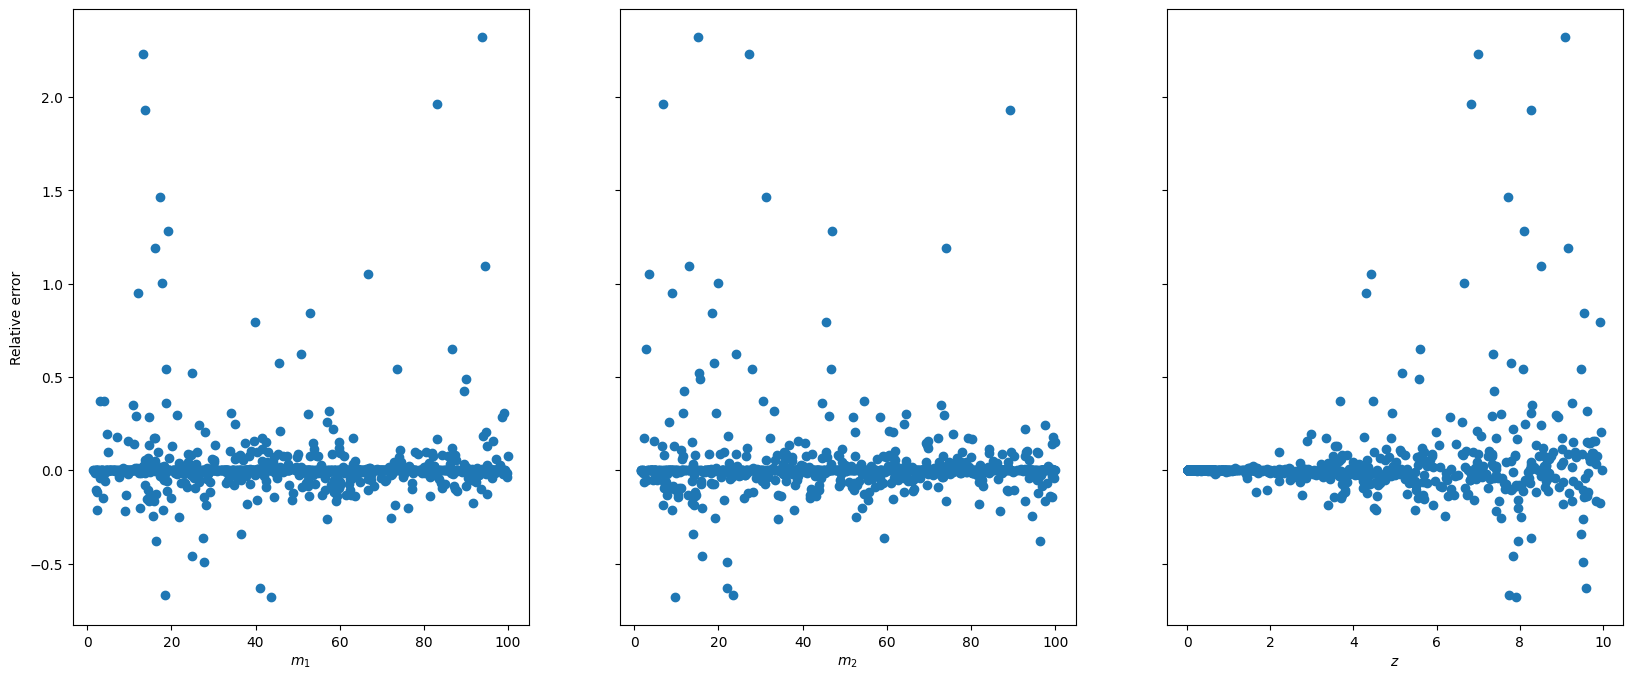

133 88 39 30


In [13]:
rel_err = (interpolated_pdet - pdet_test) / pdet_test

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 8), sharey=True)

for ax, grid, xlb in zip(axes, (m1test, m2test, ztest), (r'$m_1$', r'$m_2$', r'$z$')):
    ax.scatter(grid, rel_err)
    ax.set_xlabel(xlb)
axes[0].set_ylabel('Relative error')

plt.show()

print(*[np.sum(rel_err > lv) for lv in (0.05, 0.1, 0.5, 1)])